# Project 5B: Training Your Own Diffusion Model!

## Setup environment

In [1]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00


In [2]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import mediapy as media
from tqdm.notebook import tqdm
import torch
import numpy as np

# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [3]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.process(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.process = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, padding=0, stride=7),
            nn.BatchNorm2d(in_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)

## Implementing Unconditional UNet

In [4]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.conv2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.out = nn.Conv2d(num_hiddens, in_channels,kernel_size = 3, padding = 1,stride = 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        layer_1 = self.conv1(x)
        layer_2 = self.down1(layer_1)
        layer_3 = self.down2(layer_2)
        flattened = self.flatten(layer_3)
        unflattened = self.unflatten(flattened)
        layer_3 = torch.cat([unflattened, layer_3], dim = 1)
        layer_3_up = self.up1(layer_3)
        layer_2 = torch.cat([layer_2, layer_3_up], dim = 1)
        layer_2_up = self.up2(layer_2)
        layer_1 = torch.cat([layer_1, layer_2_up], dim = 1)
        layer_1 = self.conv2(layer_1)
        out = self.out(layer_1)

        return out

In [9]:
class NoiseAdittion(nn.Module):

  def __init__(self, sigma=None):
    super().__init__()
    self.sigma = sigma

  def forward(self, x, sigma=None):
    self.sigma = sigma if sigma is not None else self.sigma

    if self.sigma is None:
      raise ValueError("No sigma initialized")

    noise = torch.randn_like(x) * self.sigma

    return x + noise

In [6]:
train_data = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./data", train=False, download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.59MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
examples = torch.stack([train_data[idx][0] for idx in range(5)], dim = 0)
examples = examples.permute(0, 2, 3, 1).numpy()
media.show_images(examples, width = 56)

,,,,


In [10]:
sigmas = [0.0, 0.2, 0.4, 0.6, 0.8]
noise_adder = NoiseAdittion()
for image in examples:
  image = torch.from_numpy(image).permute(2, 0, 1)
  row_images = []
  for sigma in sigmas:
      noisy_image = noise_adder(image, sigma=sigma)
      row_images.append(noisy_image.permute(1, 2, 0).numpy())
  media.show_images(row_images, width=128, titles=[f"Sigma: {sigma}" for sigma in sigmas])

Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8


Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8


Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8


Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8


Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8


In [11]:
num_hidden = 128
batch_size = 256
num_epochs = 5
lr = 1e-4

unet = UnconditionalUNet(1, num_hidden)
unet.to("cuda")
noise_adder = NoiseAdittion(sigma=0.5)
noise_adder.to("cuda")

optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_loss = []
test_loss = []

display_epochs = [0,4]
validation_freq = 1

train_iteration_loss = []

for epoch in tqdm(range(num_epochs)):
    # Train
    unet.train()
    train_epoch_loss = 0.0
    for batch, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        data = data.to("cuda")

        noisy_data = noise_adder(data)
        output = unet(noisy_data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()

        # Iteration loss
        train_iteration_loss.append(loss.item())
        train_epoch_loss += loss.item()

    train_loss.append(train_epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]}")

    if epoch in display_epochs:
        # Testing
        unet.eval()
        indexes = np.random.choice(len(test_data), size = 3, replace=False)
        ex_imgs = torch.stack([test_data[idx][0] for idx in indexes], dim = 0)
        ex_imgs = ex_imgs.to("cuda")
        ex_imgs_noisy = noise_adder(ex_imgs)
        ex_imgs_pred = unet(ex_imgs_noisy)
        ex_imgs, ex_imgs_noisy, ex_imgs_pred = (
            ex_imgs.detach().cpu().permute(0, 2, 3, 1).numpy(),
            ex_imgs_noisy.detach().cpu().permute(0, 2, 3, 1).numpy(),
            ex_imgs_pred.detach().cpu().permute(0, 2, 3, 1).numpy(),
        )
        print(f"Sample denoised images for epoch {epoch+1}")

        for i in range(3):
            media.show_images(
                [ex_imgs[i], ex_imgs_noisy[i], ex_imgs_pred[i]],
                width=128,
                titles=["Original", "Noisy", "Denoised"],
            )

    if epoch % validation_freq == 0:
        unet.eval()
        test_epoch_loss = 0.0
        with torch.no_grad():
            for batch, (data, _) in enumerate(test_dataloader):
                data = data.to("cuda")
                noisy_data = noise_adder(data)
                output = unet(noisy_data)
                loss = loss_fn(output, data)
                test_epoch_loss += loss.item()
            test_loss.append(test_epoch_loss / len(test_dataloader))
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss[-1]}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 0.022698215910411896
Sample denoised images for epoch 1


Original,Noisy,Denoised


Original,Noisy,Denoised


Original,Noisy,Denoised


Epoch 1/5, Test Loss: 0.011828095861710608
Epoch 2/5, Train Loss: 0.01074382261709964
Epoch 2/5, Test Loss: 0.009760466846637427
Epoch 3/5, Train Loss: 0.00930078812736146
Epoch 3/5, Test Loss: 0.008779433788731694
Epoch 4/5, Train Loss: 0.008657668360528793
Epoch 4/5, Test Loss: 0.00876201766077429
Epoch 5/5, Train Loss: 0.008291645968293257
Sample denoised images for epoch 5


Original,Noisy,Denoised


Original,Noisy,Denoised


Original,Noisy,Denoised


Epoch 5/5, Test Loss: 0.008201491518411786


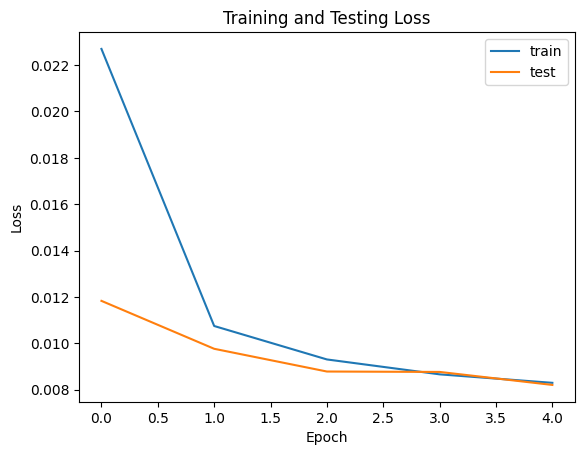

In [12]:
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss")

plt.show()

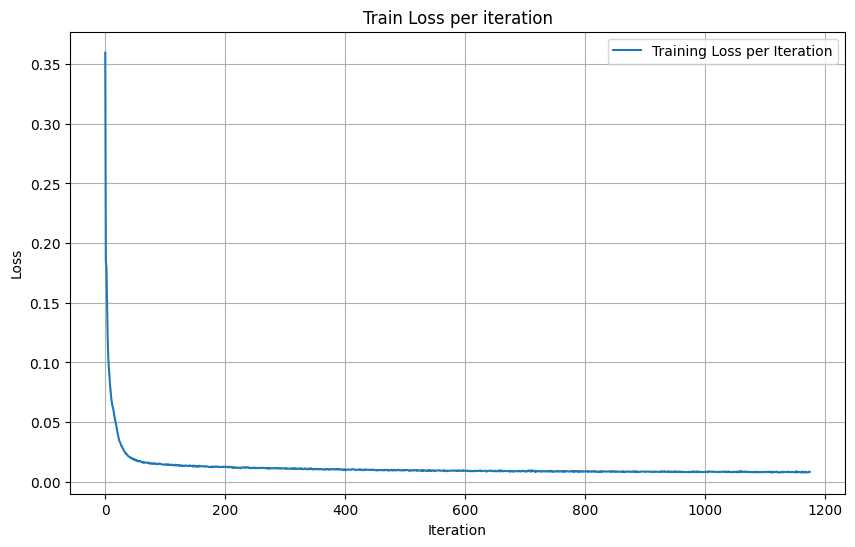

In [13]:
plt.figure(figsize = (10, 6))
plt.plot(train_iteration_loss, label="Training Loss per Iteration")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Train Loss per iteration")

plt.legend()
plt.grid()
plt.show()

In [14]:
sigmas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
example_image = test_data[np.random.choice(len(test_data), size=1, replace=False)[0]][0].unsqueeze(0)

noisy_imgs = []
denoised_imgs = []

for sigma in sigmas:
    # Add noise
    noisy_image = noise_adder(example_image, sigma=sigma)
    noisy_imgs.append(noisy_image.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

    # Denoise with UNet
    denoised_image = unet(noisy_image.to("cuda"))
    denoised_imgs.append(denoised_image.permute(0, 2, 3, 1).detach().cpu().numpy()[0])

# Display images
media.show_images(noisy_imgs, width=128, titles=[f"Sigma: {sigma}" for sigma in sigmas])
media.show_images(denoised_imgs, width=128, titles=[f"Sigma: {sigma}" for sigma in sigmas])


Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8,Sigma: 1.0


Sigma: 0.0,Sigma: 0.2,Sigma: 0.4,Sigma: 0.6,Sigma: 0.8,Sigma: 1.0


# Part 2: Training a Diffusion Model

## 2.1 Implementing a Class and Time-conditioned UNet (Time is later in the notebook)

In [15]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.process = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.process(x)


class TimeAndClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int = 64,
    ):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        self.conv1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.conv2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.out = nn.Conv2d(num_hiddens, in_channels, kernel_size = 3, padding = 1, stride = 1)
        self.fc1_t = FCBlock(1, 1)
        self.fc1_c = FCBlock(num_classes, 2 * num_hiddens)
        self.fc2_t = FCBlock(1, 1)
        self.fc2_c = FCBlock(num_classes, num_hiddens)


    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        one_hot_c = nn.functional.one_hot(c, num_classes=self.num_classes).float()

        if mask is not None:
            one_hot_c = one_hot_c * mask.unsqueeze(1)

        t = t.unsqueeze(-1)
        layer_1 = self.conv1(x)
        layer_2 = self.down1(layer_1)
        layer_3 = self.down2(layer_2)
        flattened = self.flatten(layer_3)

        t_fc1 = self.fc1_t(t)
        c_fc1 = self.fc1_c(one_hot_c)
        t_fc1 = t_fc1.view(-1, 1, 1, 1)
        c_fc1 = c_fc1.view(-1, self.num_hiddens * 2, 1, 1)
        unflattened = t_fc1 * self.unflatten(flattened) + c_fc1

        layer_3 = torch.cat([layer_3, unflattened], dim = -3)

        t_fc2 = self.fc2_t(t)
        c_fc2 = self.fc2_c(one_hot_c)
        t_fc2 = t_fc2.view(-1, 1, 1, 1)
        c_fc2 = c_fc2.view(-1, self.num_hiddens, 1, 1)

        layer_3_up = self.up1(layer_3)
        layer_3_up = t_fc2 * layer_3_up + c_fc2

        layer_2 = torch.cat([layer_2, layer_3_up], dim = -3)
        layer_2_up = self.up2(layer_2)
        layer_1 = torch.cat([layer_1, layer_2_up], dim = -3)
        layer_1 = self.conv2(layer_1)

        out = self.out(layer_1)

        return out

## 2.2 Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [16]:
from math import sqrt
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """

    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts).cuda()
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    sqrt_betas = torch.sqrt(betas)
    sqrt_alpha_bars = torch.sqrt(alpha_bars)
    sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_recip_alpha_bars = torch.sqrt(1.0 / alpha_bars)

    return  {
        "betas": betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars,
        "sqrt_betas": sqrt_betas,
        "sqrt_alpha_bars": sqrt_alpha_bars,
        "sqrt_one_minus_alpha_bars": sqrt_one_minus_alpha_bars,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_recip_alpha_bars": sqrt_recip_alpha_bars,
    }

In [17]:
def ddpm_forward(
    unet: TimeAndClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    t = torch.randint(0, num_ts, (x_0.shape[0],), device=x_0.device)
    noise = torch.randn_like(x_0)

    x_t = (
        ddpm_schedule["sqrt_alpha_bars"][t].view(-1, 1, 1, 1) * x_0 +
        ddpm_schedule["sqrt_one_minus_alpha_bars"][t].view(-1, 1, 1, 1) * noise
    )

    mask = torch.rand(x_0.shape[0], device = x_0.device) >= p_uncond
    predicted_noise = unet(x_t, c, t.float() / num_ts, mask)
    loss = nn.functional.mse_loss(predicted_noise, noise)

    return loss


In [18]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeAndClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh,
    num_ts: int,
    guidance_scale: float,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeandClassConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.
        c: Number of classes
        guidence scale

    Returns:
        (N, C, H, W) final sample.
    """

    unet.eval()
    x_t = torch.randn((c.shape[0],1, * img_wh), device = c.device)

    for ts in reversed(range(num_ts)):
        torch.manual_seed(seed)
        t = torch.full((c.shape[0],), ts / num_ts, device = c.device).float()

        mask_cond = torch.ones_like(c)
        cond_pred_noise = unet(x_t, c, t, mask_cond)

        mask_uncond = torch.zeros_like(c)
        uncond_pred_noise = unet(x_t, c, t, mask_uncond)


        pred_noise = uncond_pred_noise + guidance_scale * (cond_pred_noise - uncond_pred_noise)

        alpha_ts = ddpm_schedule["alphas"][ts]
        alpha_bar_ts = ddpm_schedule["alpha_bars"][ts]
        beta_ts = ddpm_schedule["betas"][ts]

        if ts > 0:
            alpha_bar_ts_prev = ddpm_schedule["alpha_bars"][ts - 1]
        else:
            alpha_bar_ts_prev = torch.tensor(1.0,device = c.device)

        c1 = 1 / torch.sqrt(alpha_ts)
        c2 = beta_ts/torch.sqrt(1-alpha_bar_ts)
        mean_ts = c1*(x_t - c2*pred_noise)
        var_ts = alpha_bar_ts_prev - alpha_bar_ts

        if ts > 0:
            sigma_ts = torch.sqrt((1 - alpha_bar_ts_prev) / (1 - alpha_bar_ts) * beta_ts)

            z = torch.randn_like(x_t)
            x_t = mean_ts + sigma_ts*z
        else:
            x_t = mean_ts
        seed += 1

    return x_t

In [19]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeAndClassConditionalUNet,
        betas=(1e-4, 0.02),
        num_ts: int = 400,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.beta_range = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in self.ddpm_schedule.items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: Class tensor

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        seed: int = 0,
        guidance_scale: float = 10.0,
    ):
        return ddpm_sample(self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Batch 1/235, Loss: 1.2581090927124023
Epoch 1/20, Batch 101/235, Loss: 0.0848289281129837
Epoch 1/20, Batch 201/235, Loss: 0.056577786803245544
Epoch 1/20, Train Loss: 0.11030811163339209


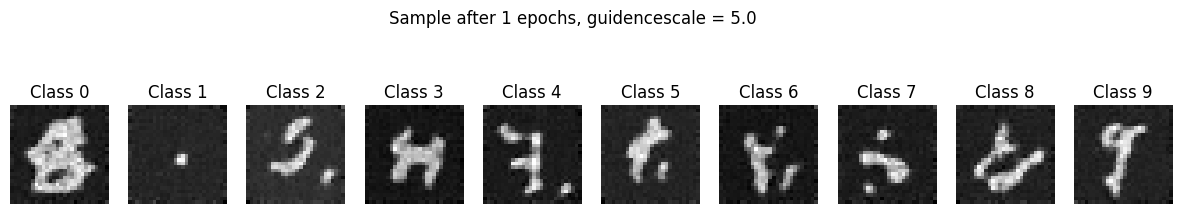

Epoch 2/20, Batch 1/235, Loss: 0.06895481050014496
Epoch 2/20, Batch 101/235, Loss: 0.05249746888875961
Epoch 2/20, Batch 201/235, Loss: 0.04793331399559975
Epoch 2/20, Train Loss: 0.053187733016749644
Epoch 3/20, Batch 1/235, Loss: 0.043502286076545715
Epoch 3/20, Batch 101/235, Loss: 0.04125117138028145
Epoch 3/20, Batch 201/235, Loss: 0.03712386265397072
Epoch 3/20, Train Loss: 0.04514258729016527
Epoch 4/20, Batch 1/235, Loss: 0.038684915751218796
Epoch 4/20, Batch 101/235, Loss: 0.0375857874751091
Epoch 4/20, Batch 201/235, Loss: 0.03941810876131058
Epoch 4/20, Train Loss: 0.04098255913308326
Epoch 5/20, Batch 1/235, Loss: 0.04296479746699333
Epoch 5/20, Batch 101/235, Loss: 0.0375252403318882
Epoch 5/20, Batch 201/235, Loss: 0.03426823019981384
Epoch 5/20, Train Loss: 0.03727820798596169


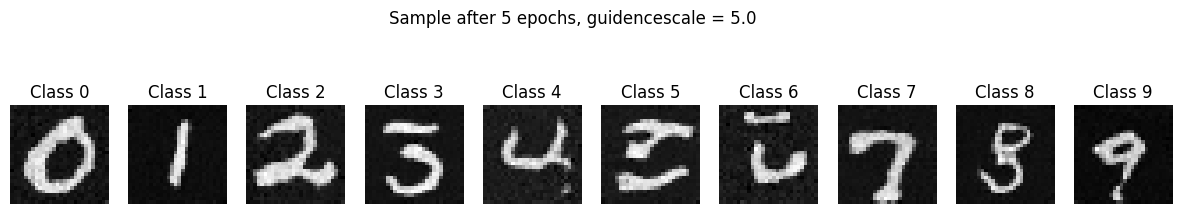

Epoch 6/20, Batch 1/235, Loss: 0.03575970605015755
Epoch 6/20, Batch 101/235, Loss: 0.03468632325530052
Epoch 6/20, Batch 201/235, Loss: 0.03262777253985405
Epoch 6/20, Train Loss: 0.03574854573036762
Epoch 7/20, Batch 1/235, Loss: 0.03331046551465988
Epoch 7/20, Batch 101/235, Loss: 0.0370805487036705
Epoch 7/20, Batch 201/235, Loss: 0.03393897786736488
Epoch 7/20, Train Loss: 0.033345084463028196
Epoch 8/20, Batch 1/235, Loss: 0.03100108541548252
Epoch 8/20, Batch 101/235, Loss: 0.03340543061494827
Epoch 8/20, Batch 201/235, Loss: 0.03039366379380226
Epoch 8/20, Train Loss: 0.03228212205019403
Epoch 9/20, Batch 1/235, Loss: 0.030655568465590477
Epoch 9/20, Batch 101/235, Loss: 0.028742482885718346
Epoch 9/20, Batch 201/235, Loss: 0.030256718397140503
Epoch 9/20, Train Loss: 0.03127515189191128
Epoch 10/20, Batch 1/235, Loss: 0.03055308759212494
Epoch 10/20, Batch 101/235, Loss: 0.033622320741415024
Epoch 10/20, Batch 201/235, Loss: 0.03011174499988556
Epoch 10/20, Train Loss: 0.03038

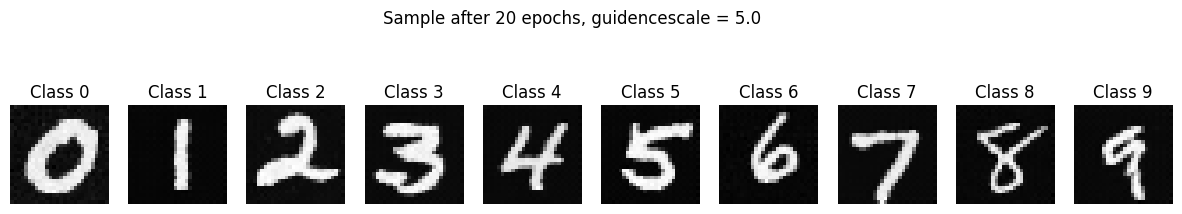

In [20]:
num_hidden = 128
batch_size = 256
num_epochs = 20
lr = 1e-4

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

unet = TimeAndClassConditionalUNet(1, 10, num_hidden)
ddpm_model = DDPM(unet = unet)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr = lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm_model.to(device)

loss_batch = []
loss_epoch = []

for epoch in tqdm(range(num_epochs)):
    ddpm_model.train()
    train_epoch_loss = 0.0
    for batch,(data,target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        loss = ddpm_model(data,target)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        loss_batch.append(batch_loss)
        train_epoch_loss += batch_loss

        if batch % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch+1}/{len(train_dataloader)}, Loss: {batch_loss}")

    train_epoch_loss /= len(train_dataloader)
    loss_epoch.append(train_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_epoch_loss}")

    if epoch in [0,4, num_epochs-1]:
      ddpm_model.eval()

      with torch.no_grad():
        c = torch.arange(10).to(device)
        img_wh= (28,28)
        guide_scale = 5.0
        samples = ddpm_model.sample(c = c, img_wh = img_wh, seed = epoch, guidance_scale = guide_scale)
        samples = samples.detach().cpu()

        fix,axis = plt.subplots(1,10,figsize= (15,3))
        for i in range(10):
          axis[i].imshow(samples[i,0], cmap = 'grey')
          axis[i].axis("off")
          axis[i].set_title(f'Class {c[i].item()}')

        plt.suptitle(f'Sample after {epoch +1} epochs, guidencescale = {guide_scale}')
        plt.show()

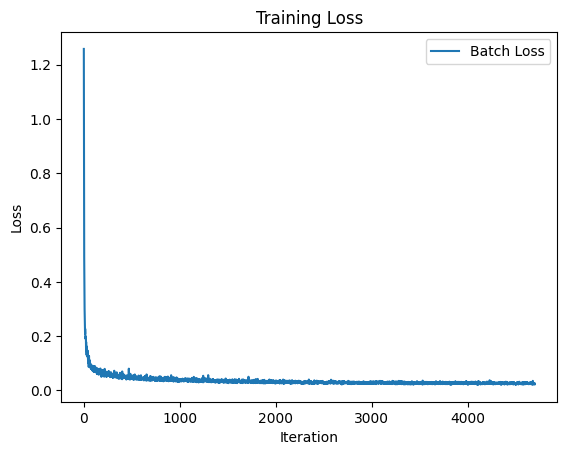

In [21]:
plt.plot(loss_batch, label='Batch Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.legend()
plt.show()

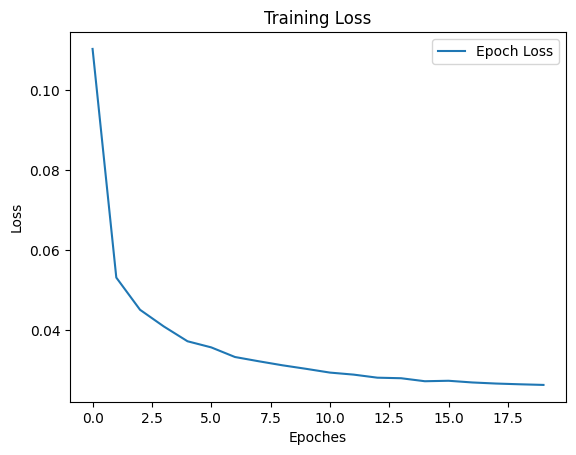

In [22]:
plt.plot(loss_epoch, label='Epoch Loss')

plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.legend()
plt.show()

### Implementing time-conditioned UNet

In [23]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int = 64,
    ):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.conv1 = ConvBlock(in_channels, num_hiddens)
        self.down1 = DownBlock(num_hiddens, num_hiddens)
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)
        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2)
        self.up1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up2 = UpBlock(num_hiddens * 2, num_hiddens)
        self.conv2 = ConvBlock(num_hiddens * 2, num_hiddens)
        self.out = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1, stride=1)
        self.fc1_t = FCBlock(1, num_hiddens * 2)
        self.fc2_t = FCBlock(1, num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        t = t.unsqueeze(-1)
        layer_1 = self.conv1(x)
        layer_2 = self.down1(layer_1)
        layer_3 = self.down2(layer_2)
        flattened = self.flatten(layer_3)
        t_fc1 = self.fc1_t(t)
        t_fc1 = t_fc1.view(-1, self.num_hiddens * 2, 1, 1)
        unflattened = t_fc1 * self.unflatten(flattened)
        layer_3 = torch.cat([layer_3, unflattened], dim = -3)
        t_fc2 = self.fc2_t(t)
        t_fc2 = t_fc2.view(-1, self.num_hiddens, 1, 1)
        layer_3_up = self.up1(layer_3)
        layer_3_up = t_fc2 * layer_3_up
        layer_2 = torch.cat([layer_2, layer_3_up], dim = -3)
        layer_2_up = self.up2(layer_2)
        layer_1 = torch.cat([layer_1, layer_2_up], dim = -3)
        layer_1 = self.conv2(layer_1)
        out = self.out(layer_1)

        return out

In [24]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper for time-conditioned U-Net.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        p_uncond: float, unconditional probability (not used here).
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    t = torch.randint(0, num_ts, (x_0.shape[0],), device=x_0.device)
    noise = torch.randn_like(x_0)

    x_t = (
        ddpm_schedule["sqrt_alpha_bars"][t].view(-1, 1, 1, 1) * x_0 +
        ddpm_schedule["sqrt_one_minus_alpha_bars"][t].view(-1, 1, 1, 1) * noise
    )

    t_normalized = t.float() / num_ts
    predicted_noise = unet(x_t, t_normalized)
    loss = nn.functional.mse_loss(predicted_noise, noise)

    return loss

In [25]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 10.0,
    seed: int = 0,
) -> torch.Tensor:
    """
    Algorithm 2 of the DDPM paper for time-conditioned U-Net.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, classifier-free guidance scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """

    unet.eval()
    device = next(unet.parameters()).device
    batch_size = 20
    x_t = torch.randn((batch_size, 1, *img_wh), device=device)

    for ts in reversed(range(num_ts)):
        torch.manual_seed(seed)
        t = torch.full((batch_size,), ts / num_ts, device=device).float()
        pred_noise = unet(x_t, t)
        alpha_ts = ddpm_schedule["alphas"][ts]
        alpha_bar_ts = ddpm_schedule["alpha_bars"][ts]
        beta_ts = ddpm_schedule["betas"][ts]

        if ts > 0:
            alpha_bar_ts_prev = ddpm_schedule["alpha_bars"][ts - 1]
        else:
            alpha_bar_ts_prev = torch.tensor(1.0, device=device)

        c1 = 1 / torch.sqrt(alpha_ts)
        c2 = beta_ts / torch.sqrt(1 - alpha_bar_ts)
        mean_ts = c1 * (x_t - c2 * pred_noise)
        var_ts = alpha_bar_ts_prev - alpha_bar_ts

        if ts > 0:
            sigma_ts = torch.sqrt((1 - alpha_bar_ts_prev) / (1 - alpha_bar_ts) * beta_ts)
            z = torch.randn_like(x_t)
            x_t = mean_ts + sigma_ts * z
        else:
            x_t = mean_ts
        seed += 1

    return x_t

In [26]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas=(1e-4, 0.02),
        num_ts: int = 400,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.beta_range = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in self.ddpm_schedule.items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh,
        seed: int = 0,
        guidance_scale: float = 5.0,
    ):
        """
        Args:
            img_wh: tuple, image width and height.
            seed: int, random seed.
            guidance_scale: float, classifier-free guidance scale.

        Returns:
            Generated samples as (N, C, H, W) tensor.
        """

        return ddpm_sample(self.unet, self.ddpm_schedule, img_wh, self.num_ts, guidance_scale, seed)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Batch 1/235, Loss: 1.1083788871765137
Epoch 1/20, Batch 101/235, Loss: 0.06994741410017014
Epoch 1/20, Batch 201/235, Loss: 0.06002473831176758
Epoch 1/20, Train Loss: 0.0985284650103843


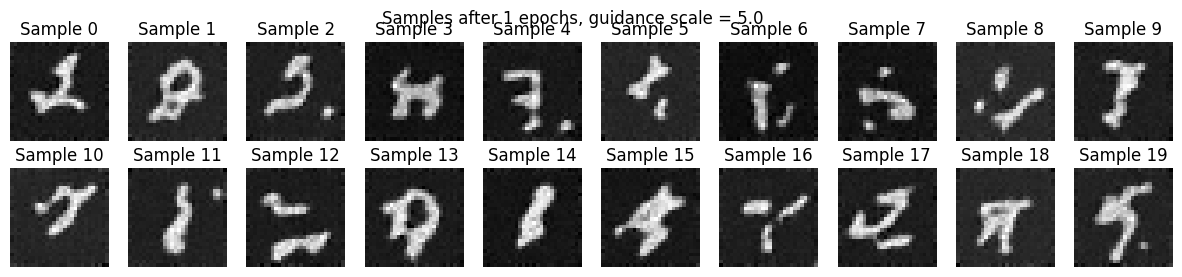

Epoch 2/20, Batch 1/235, Loss: 0.06160111352801323
Epoch 2/20, Batch 101/235, Loss: 0.05434092506766319
Epoch 2/20, Batch 201/235, Loss: 0.044687189161777496
Epoch 2/20, Train Loss: 0.04980387080540048
Epoch 3/20, Batch 1/235, Loss: 0.05544039234519005
Epoch 3/20, Batch 101/235, Loss: 0.04229535907506943
Epoch 3/20, Batch 201/235, Loss: 0.03819442167878151
Epoch 3/20, Train Loss: 0.04275032908041426
Epoch 4/20, Batch 1/235, Loss: 0.04431634396314621
Epoch 4/20, Batch 101/235, Loss: 0.03696329519152641
Epoch 4/20, Batch 201/235, Loss: 0.03948718681931496
Epoch 4/20, Train Loss: 0.038575448872561154
Epoch 5/20, Batch 1/235, Loss: 0.03798802196979523
Epoch 5/20, Batch 101/235, Loss: 0.03271310403943062
Epoch 5/20, Batch 201/235, Loss: 0.032006073743104935
Epoch 5/20, Train Loss: 0.03622625751539748


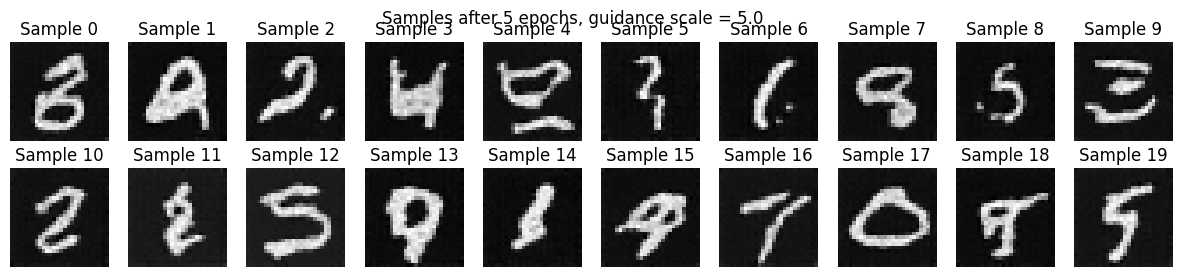

Epoch 6/20, Batch 1/235, Loss: 0.03514053672552109
Epoch 6/20, Batch 101/235, Loss: 0.03443673253059387
Epoch 6/20, Batch 201/235, Loss: 0.03215054050087929
Epoch 6/20, Train Loss: 0.034083706425859575
Epoch 7/20, Batch 1/235, Loss: 0.032502561807632446
Epoch 7/20, Batch 101/235, Loss: 0.029580462723970413
Epoch 7/20, Batch 201/235, Loss: 0.030998097732663155
Epoch 7/20, Train Loss: 0.03222993017035596
Epoch 8/20, Batch 1/235, Loss: 0.03137412667274475
Epoch 8/20, Batch 101/235, Loss: 0.029685497283935547
Epoch 8/20, Batch 201/235, Loss: 0.032765358686447144
Epoch 8/20, Train Loss: 0.031186313134558656
Epoch 9/20, Batch 1/235, Loss: 0.02963658608496189
Epoch 9/20, Batch 101/235, Loss: 0.0306828785687685
Epoch 9/20, Batch 201/235, Loss: 0.03068223036825657
Epoch 9/20, Train Loss: 0.03031836672032133
Epoch 10/20, Batch 1/235, Loss: 0.03700642287731171
Epoch 10/20, Batch 101/235, Loss: 0.031467799097299576
Epoch 10/20, Batch 201/235, Loss: 0.026873091235756874
Epoch 10/20, Train Loss: 0.0

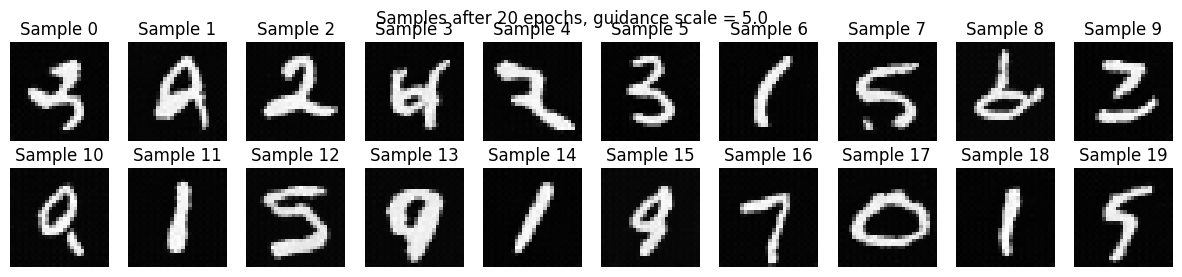

In [28]:
num_hidden = 128
batch_size = 256
num_epochs = 20
lr = 1e-4

# Init dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle = True)

# Init time-conditioned U-Net + DDPM model
unet = TimeConditionalUNet(1, num_hidden)
ddpm_model = DDPM(unet=unet)

# Optimizer and device setup
optimizer = torch.optim.Adam(ddpm_model.parameters(), lr = lr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm_model.to(device)

# Losses
loss_batch = []
loss_epoch = []

for epoch in tqdm(range(num_epochs)):
    ddpm_model.train()
    train_epoch_loss = 0.0

    for batch, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        data = data.to(device)
        loss = ddpm_model(data)
        loss.backward()
        optimizer.step()

        # Log losses
        batch_loss = loss.item()
        loss_batch.append(batch_loss)
        train_epoch_loss += batch_loss

        if batch % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch+1}/{len(train_dataloader)}, Loss: {batch_loss}")

    # Average loss per epoch
    train_epoch_loss /= len(train_dataloader)
    loss_epoch.append(train_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_epoch_loss}")

    # Visualization and sampling
    if epoch in [0, 4, num_epochs - 1]:
        ddpm_model.eval()
        with torch.no_grad():
          img_wh = (28, 28)
          guide_scale = 5.0
          samples = ddpm_model.sample(
            img_wh=img_wh,
            seed=epoch,
            guidance_scale=guide_scale,
         )
          samples = samples.detach().cpu()

          # Plot the generated samples
          fig, axes = plt.subplots(2, 10, figsize=(15, 3))
          for i in range(20):
              row = i//10
              col = i % 10
              axes[row,col].imshow(samples[i, 0], cmap='gray')
              axes[row,col].axis("off")
              axes[row,col].set_title(f'Sample {i}')
          plt.suptitle(f'Samples after {epoch + 1} epochs, guidance scale = {guide_scale}')
          plt.show()

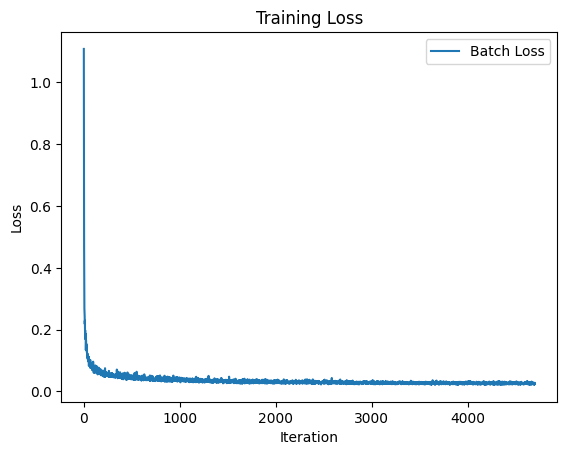

In [29]:
plt.plot(loss_batch, label='Batch Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()